# Probes
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/VirtualBrainLab/urchin-examples/blob/main/basics/probes.ipynb)

## Install Urchin

Urchin is a Python package stored on PyPI, the following code needs to be run the first time you use Urchin in a Python environment. 

Urchin's full documentation can be found [on our website](https://virtualbrainlab.org/urchin/installation_and_use.html).

In [ ]:
#Installing urchin
!pip install oursin -U

## Setup Urchin and open the renderer webpage 

By default Urchin opens the 3D renderer in a webpage. Make sure pop-ups are enabled, or the page won't open properly. You can also open the renderer site yourself by replacing [ID here] with the ID that is output by the call to `.setup()` at https://data.virtualbrainlab.org/Urchin/?ID=[ID here]

Note that Urchin communicates to the renderer webpage through an internet connection, we don't currently support offline use (we hope to add support in the future).

In [1]:
#Importing necessary libraries:
import oursin as urchin
import pandas as pd
urchin.setup(standalone= True, localhost= True)


(URN) connected to server
Login sent with ID: e4af0d8b, copy this ID into the renderer to connect.


## Data source
For this tutorial we'll used data from Nick Steinmetz, as published in Nature 2019.

In [2]:
#Function for easily pulling in data:
#url = link to google sheet (on editing mode) as a string
def get_data(url):
    data = url.replace("/edit#gid=", "/export?format=csv&gid=")
    df = pd.read_csv(data)
    return df

Some modifications to the data need to be made because of how the data was recorded in order to match the proper Urchin input format.

In [3]:
probe_data = get_data('https://docs.google.com/spreadsheets/d/1T-RG3d_MIBXZKmrGmLnsU-O7GmwY09Z0FY6yqbYyZXI/edit#gid=1457359713')
probe_data["theta"] = -probe_data["theta"] +90
probe_data["phi"] = -probe_data["phi"] +270 

#### A preview of the data table:
ML, AP, and DV, refer to the coordinates of the tip of the probe. The phi and theta angles are the azimuth and elevation angles. The colors are correlated with the colors of the probes from the graphic published in the paper, so you can compare the probes generated here with the published data.

In [4]:
probe_data.head()

,session,ml,ap,dv,phi,theta,color
0,1,4990.354988,4463.941496,4907.275550,367.040203,98.599869,#EE204D
1,1,3170.782413,8732.329581,4900.724878,217.514548,105.903551,#EE204D
2,2,2562.465091,7686.413000,4851.170969,215.946819,107.513591,#EE204D
3,2,3707.683990,9400.993675,4086.404032,381.000255,98.227467,#EE204D
4,3,3312.941208,8478.681979,4061.106429,387.548431,104.063265,#EE204D


## Setup the scene

Probes can only be placed within an Atlas, so we do need to load one before proceeding. Let's load the CCF

In [5]:
urchin.ccf25.load()

Now let's load a transparent layer of the brain, so that we can get a better idea of where the probes were placed.

In [6]:
#Generating overall brain image:
urchin.ccf25.grey.set_visibility(True)
urchin.ccf25.grey.set_material('transparent-unlit')
urchin.ccf25.grey.set_alpha(0.2)

Throughout this tutorial, we'll use the screenshot function on the main camera to see what effect we had on the scene. Note that because taking screenshots requires waiting for data to come back, you need to use the Python `await` keyword.

(Camera receive) Camera CameraMain received an image
(Camera receive) CameraMain complete


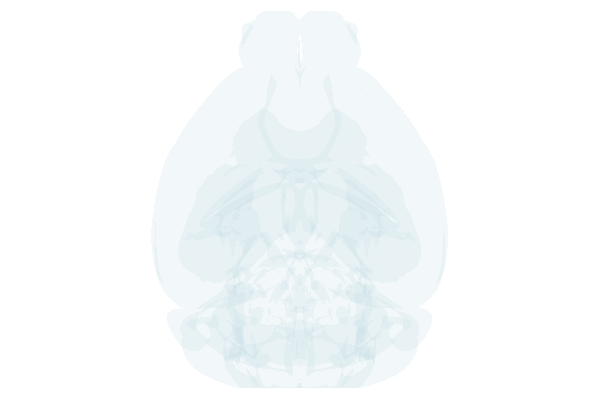

In [7]:
await urchin.camera.main.screenshot(size=[600,400])

# Probes

This tutorial walks through loading a dataset of probes. To creating indivual probes, follow the same format of creating individual neurons.

Since using the full dataset, we are creating as many probes as there are entries in the dataframe. Nothing will display, as there are no properties of the probes defined yet. This creates a list of probe objects called `probes`.

In [8]:
#Creating probes
num_probes = len(probe_data) # finding the total number of probes
probes = urchin.probes.create(num_probes) # creating that amount of probes

Setting colors first allow you to better see the probes in all future actions. Since we have the colors determined for each probe in the data, the column of colors is simply pulled in as a list to directly match up with each probe. Notice the colors within the data table are stored as hex codes, but Urchin can also take int and float rgb values to set color.

In [9]:
#Setting probe colors
urchin.probes.set_colors(probes,list(probe_data.loc[:,"color"]))

(Camera receive) Camera CameraMain received an image
(Camera receive) CameraMain complete


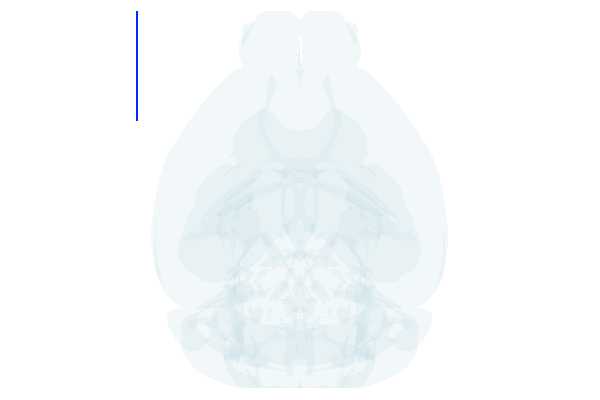

In [10]:
await urchin.camera.main.screenshot(size=[600,400])

The plural functions of probes all rely on lists of the probe opjects. Each position coordinate of a probe is a list of 3 coordinates, so the easiest to do this with multiple probes is to create a list of the three coordinates, within a greater list where each index matches the respective probe. Urchin takes in position coordinates in the format of (ap, ml, dv). This is pulling the coordinates directly from the data table displayed above.

In [11]:
# Setting probe positions
# putting in proper formating:
probe_positions = [] # creating empty list for the positions of each probe
for probe in range(num_probes): # cycling through each probe
    probe_pos = [probe_data.loc[probe, "ap"],probe_data.loc[probe, "ml"], probe_data.loc[probe, "dv"]] # creating list of position coordinates in proper order
    probe_positions.append(probe_pos) #adding each coordinate to positions list 
urchin.probes.set_positions(probes, probe_positions) #setting the positions within the renderer

(Camera receive) Camera CameraMain received an image
(Camera receive) CameraMain complete


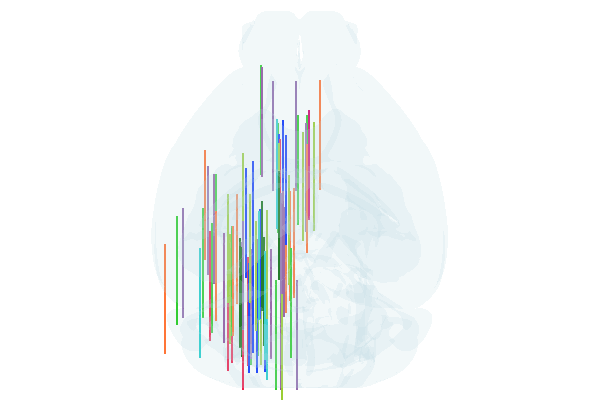

In [12]:
await urchin.camera.main.screenshot(size=[600,400])

Setting the angles of the probes follows a similar format to setting the position. The phi and theta values from the data are passed in, along with a spin value of 0.

In [13]:
#Setting probe angles
probe_angles = [] # creating empty list to hold angles for each probe
for probe in range(num_probes): # cycling through each probe
    probe_ang = [probe_data.loc[probe, "phi"],probe_data.loc[probe, "theta"], 0] # grabbing the respective angles for each probe to put into a list
    probe_angles.append(probe_ang) # adding each list of angles to the overall list to line up with each probe
urchin.probes.set_angles(probes, probe_angles) # setting the angles of each probe within the renderer

(Camera receive) Camera CameraMain received an image
(Camera receive) CameraMain complete


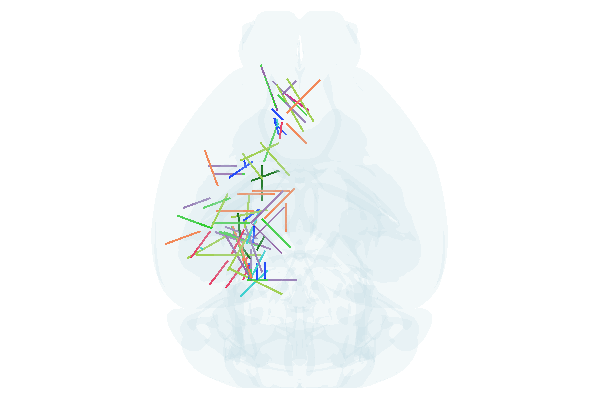

In [14]:
await urchin.camera.main.screenshot(size=[600,400])

Now view the probes in different angles, and compare to the figure displayed in the paper. Drag the brain around to see how the probes interact! See the areas and the neurons tutorial to see how to generate more useful information in the same display as the probes.

In [18]:
urchin.camera.main.set_rotation_coronal(True)

(Camera receive) Camera CameraMain received an image
(Camera receive) CameraMain complete


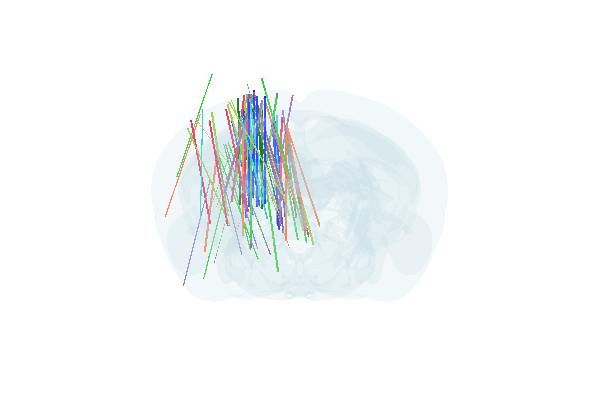

In [19]:
await urchin.camera.main.screenshot(size=[600,400])

In [20]:
urchin.camera.main.set_rotation_sagittal(True)

(Camera receive) Camera CameraMain received an image
(Camera receive) CameraMain complete


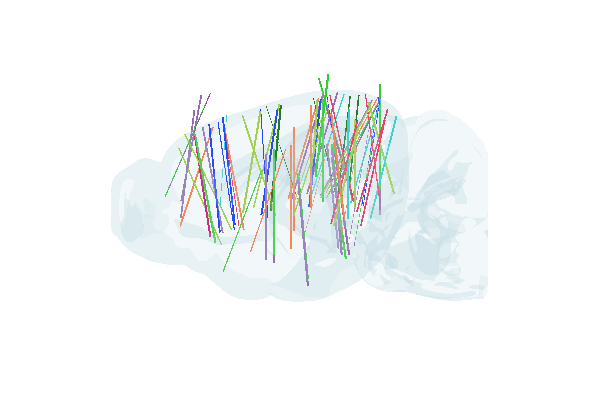

In [21]:
await urchin.camera.main.screenshot(size=[600,400])